# Research progress
## Statistical significance analysis
### General description

In order to make a statistically justified decision about which data are usable for making predictions of the diagnosis and which are not, we will consider two patient populations - patients who was diagnosed with heart disease ($X | y = 1$) and patients who wasn't ($X | y = 0$)<br>
Then, for each predictor of each population, we will calculate the parameters of the population - the mean and standard deviation:

$$
\begin{equation}
  \mu_{X, p(X|y = 0)} = \sum\limits_{i} x_{i}  p(x_{i} | y = 0); \sigma_{X, p(X|y = 0)} = \sqrt{\sum\limits_{i}(x_{i} - \mu_{X, p(X|y = 0)})^{2}}
\tag{2}
\end{equation}
$$

$$
\begin{equation}
  \mu_{X, p(X|y = 1)} = \sum\limits_{j} x_{j}  p(x_{j} | y = 1); \sigma_{X, p(X|y = 1)} = \sqrt{\sum\limits_{j}(x_{j} - \mu_{X, p(X|y = 1)})^{2}}
\tag{3}
\end{equation}
$$

Since the probability distributions $p(X | y = 0)$ and $p(X | y = 1)$ are unknown, sample estimates of these parameters will be calculated.<br>
And finally, a t-test will show whether a given predictor came from its population ("alternative hypothesis"), or the difference in population parameters for a given predictor (if any) is not statistically significant ("null hypothesis"). There are different types of t-test for different applications. In this work, we will use a two-tailed independent t-test, which does not assume equality of variations in the distributions being tested (known as Welch's t-test). Also we will set significance level $\alpha = 0.05$. This means that any predictor whose p-value is greater than $\alpha = 0.05$ will be considered to have failed the test and will not be used in further research.<br>
The calculation results are shown in Figures 1-1 and 1-2 below.

In [10]:
import pandas as pd
import numpy as np
import torch

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

from fedddot_transforms.pca import pca
from fedddot_transforms.lda import LDA

import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

%store -r original_data

To better see the differences in the mean values in the figures, we will split the dataset into subsets - with large means, and with small ones:

In [11]:
large_means_columns = [
    'age', 'trestbps', 'chol', 'thalach'
]
small_means_columns = [
    'sex', 'typical angina', 
    'atypical angina', 'non-anginal pain', 
    'asymptomatic', 'thal norm', 'thal fixed def', 
    'thal reversable def', 'ecg norm', 
    'ecg ST-T abnormal', 'ecg hypertrophy',
    'fbs', 'exang', 'oldpeak',
    'slope', 'ca'
]

Then we create a pivot with rows divided by the "num" parameter (sick and healthy), and columns aggregated by the mean and standard deviation:

In [12]:
# pivot_table contains the sample mean and sample std for each population ('num' = 0 and 'num' = 1)
pivot_table = pd.pivot_table(
    data = original_data,
    values = large_means_columns + small_means_columns,
    index = ['num'],
    aggfunc = [np.mean, np.std]
)

Finnaly we visualize the data and perform the t-test:

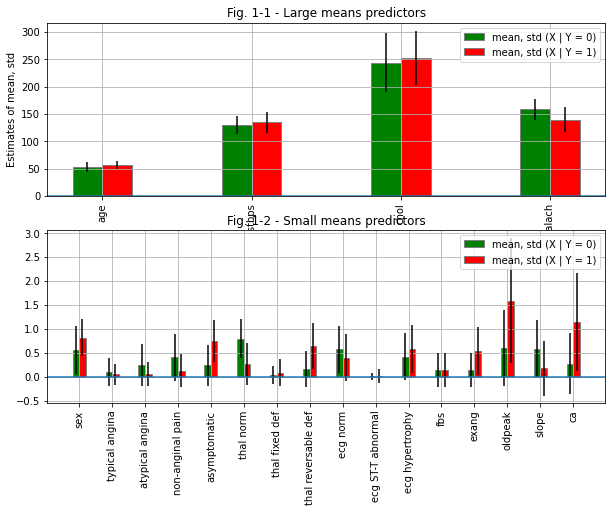

In [13]:

bar_width = 0.2

fig, (bar_larges, bar_smalls) = plt.subplots(nrows = 2, ncols = 1, figsize =(10, 7))

x_coords = np.arange(len(large_means_columns))
bar_larges.bar(
    x_coords - bar_width / 2,
    pivot_table.loc[0.0]['mean'][large_means_columns].values,
    color ='g',
    width = bar_width,
    edgecolor ='grey',
    yerr = pivot_table.loc[0.0]['std'][large_means_columns].values,
    align = 'center', label ='mean, std (X | Y = 0)'
)
bar_larges.bar(
    x_coords + bar_width / 2,
    pivot_table.loc[1.0]['mean'][large_means_columns].values,
    color ='r',
    width = bar_width,
    edgecolor ='grey',
    yerr = pivot_table.loc[1.0]['std'][large_means_columns].values,
    align = 'center', label ='mean, std (X | Y = 1)'
)
bar_larges.set_title('Fig. 1-1 - Large means predictors')
bar_larges.set_xlabel('Predictor label')
bar_larges.set_ylabel('Estimates of mean, std')
bar_larges.set_xticks(x_coords, large_means_columns, rotation = 90)
bar_larges.axhline(y = 0, xmin = 0, xmax = 1)
bar_larges.legend(); bar_larges.grid()

x_coords = np.arange(len(small_means_columns))
bar_smalls.bar(
    x_coords - bar_width / 2,
    pivot_table.loc[0.0]['mean'][small_means_columns].values,
    color ='g',
    width = bar_width,
    edgecolor ='grey',
    yerr = pivot_table.loc[0.0]['std'][small_means_columns].values,
    align = 'center', label ='mean, std (X | Y = 0)'
)
bar_smalls.bar(
    x_coords + bar_width / 2,
    pivot_table.loc[1.0]['mean'][small_means_columns].values,
    color ='r',
    width = bar_width,
    edgecolor ='grey',
    yerr = pivot_table.loc[1.0]['std'][small_means_columns].values,
    align = 'center', label ='mean, std (X | Y = 1)'
)
bar_smalls.set_title('Fig. 1-2 - Small means predictors')
bar_larges.set_xlabel('Predictor label')
bar_larges.set_ylabel('Estimates of mean, std')
bar_smalls.set_xticks(x_coords, small_means_columns, rotation = 90)
bar_smalls.axhline(y = 0, xmin = 0, xmax = 1)
bar_smalls.legend(); bar_smalls.grid()

# rejected_columns list contains column names of parameters which didn't pass the t-test
alpha = 0.05
rejected_columns = []
for columns_subset, bar_axis in zip((large_means_columns, small_means_columns), (bar_larges, bar_smalls)):
    x_coords = np.arange(len(columns_subset))
    dx = 1.1 * bar_width
    for i, col in enumerate(columns_subset):
        t_statistic, pvalue = stats.ttest_ind(
            original_data[original_data['num'] == 0][col].values,
            original_data[original_data['num'] == 1][col].values,
            equal_var = False,
            alternative = 'two-sided'
        )
        colour = None
        if pvalue <= alpha:
            colour = 'green'
        else:
            rejected_columns.append(col)
            colour = 'red'
        x_coords = np.arange(len(columns_subset))
        bar_axis.text(x_coords[i] + dx, 0, f'  p_val = {pvalue :.2f}', style='italic', color = colour, rotation = 90)

fig.tight_layout()
plt.show()

print(f'The following columns were rejected by the t-test:\n{rejected_columns}')

clean_data = original_data.drop(columns = rejected_columns)
print(f'A new dataset for further analysis was prepared - clean_data. It contains following columns ({len(clean_data.columns)} total including "num"):\n{list(clean_data.columns)}')

## Dimensionality reduction
### Introduction

The data we deal with in this study is relatively high-dimensional. This means that each data sample is a vector of the form: $X = (x_{1}, x_{2}, ..., x_{k})^{T}$, where in our case $k = 15$. This situation is typical for the data science, often the data dimensionality is even larger.
Working with high-dimensional data comes with following challenges:

- As the data dimensionality increases, the amount of samples required for an adequate generalization of a machine learning model increases exponentially
- In most cases, some predictors are correlated with each other, in other words, the data is redundant. Some of the predictors are irrelevant. Irrelevant and redundant features increase the building time of the classifier and reduce the classification accuracy
- It's hard to visualize and interpret high-dimensional data

Fortunately, we can reduce the dimensionality of the data. One common way to do this is called Principal Components Analysis (PCA).

In [15]:
# Since now we will work with a slightly different notation
# We will split clean_data dataframe into a dataframe of predictors X and a dataframe of labels y
X = clean_data.drop(columns = 'num')
y = clean_data['num']

Before we proceed, let's show how the original predictors are correlated with each other. To do this, we normalize the original data and show its correlation matrix

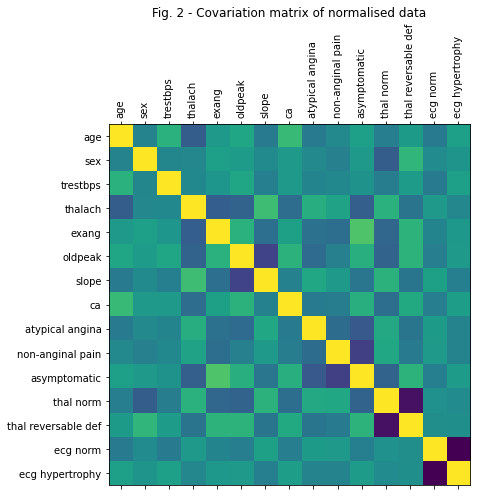

In [16]:
Xnorm = X.copy(deep = True)
Xnorm_columns = Xnorm.columns
for col in Xnorm_columns:
    Xnorm[col] = Xnorm[col] - Xnorm[col].mean()
    Xnorm[col] = Xnorm[col] / Xnorm[col].std()
Xnorm_cov = Xnorm.cov()
fig, Xnorm_cov_plot = plt.subplots(figsize = (7, 7))
Xnorm_cov_plot.matshow(Xnorm_cov)
Xnorm_cov_plot.set_title('Fig. 2 - Covariation matrix of normalised data')
Xnorm_cov_plot.set_xticks(np.arange(len(Xnorm_columns)), Xnorm_columns, rotation = 90)
Xnorm_cov_plot.set_yticks(np.arange(len(Xnorm_columns)), Xnorm_columns, rotation = 0)
fig.tight_layout()
plt.show()


From Figure 2, it is easy to see that the predictors in the original dataset are highly correlated with each other. Let's fix that!

### Principal components analysis

Principal Components Analysis (PCA) is one of the most common dimensionality reduction methods. The idea is that we project the vectors $X$ onto the eugenvectors of the covariance matrix of $X$. Obviously, these vectors form an orthogonal basis. Thus, we get the same data in a different, orthogonal (uncorrelated) basis whose coordinates are a linear combination of the original data. Finally, we can choose not all, but only a few eugenvectors corresponding to the largest eugenvalues ​​of the covariance matrix. Thus we will reduce the dimensionality of the original data to some arbitrarily chosen value.

In [17]:
# function pca takes two arguments - the original data X (pandas.DataFrame) and number of principal components to return num_pca (int),
# and returns transformed dataset Xpca (pandas.DataFrame) with columns {PC0, PC1, ..., PCk-1}, where k = num_pca,
# array of eugenvalues L and eugenvectors V (both np.ndarray)

Xpca, Lpca, Vpca = pca(X, pc_num = 3)

Since the number of dimensions in the new Xpca dataset is 3, we can easily visualize this data

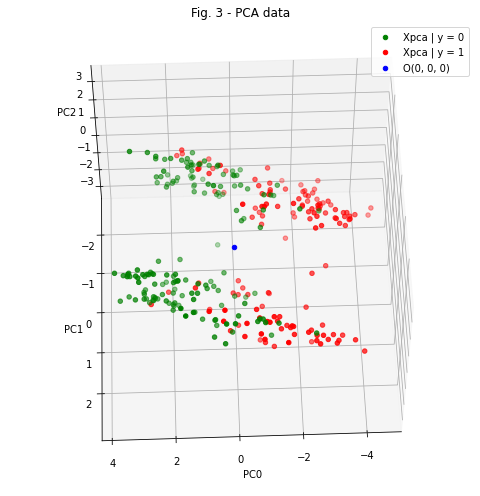

In [18]:
fig = plt.figure(figsize = (7, 7))
pca_scatter = fig.add_subplot(projection = '3d')

pca_scatter.scatter(
    Xpca[y == 0]['PC0'].values, 
    Xpca[y == 0]['PC1'].values,  
    Xpca[y == 0]['PC2'].values, 
    color ='g',
    label = 'Xpca | y = 0')
pca_scatter.scatter(
    Xpca[y == 1]['PC0'].values, 
    Xpca[y == 1]['PC1'].values,  
    Xpca[y == 1]['PC2'].values, 
    color ='r',
    label = 'Xpca | y = 1')
pca_scatter.scatter(
    0.0, 
    0.0,  
    0.0, 
    color ='b',
    label = 'O(0, 0, 0)')
pca_scatter.set_title('Fig. 3 - PCA data')
pca_scatter.legend(); pca_scatter.grid()
pca_scatter.view_init(elev = 55, azim = 88)
pca_scatter.set_xlabel(Xpca.columns[0]); pca_scatter.set_ylabel(Xpca.columns[1]); pca_scatter.set_zlabel(Xpca.columns[2])
fig.tight_layout()
plt.show()

Figure 3 is an excellent illustration of how powerful PCA can be. In the figure, we can observe 2 interesting phenomena:

- The data belonging to the considered populations (patients who was diagnosed with heart desease - red points, and patients who wasn't - green points) lie on opposite sides of some three-dimensional surface separating them. Of course, this separation is not perfect, and we can see an overlap in their distributions.
- Regardless of the diagnosis, the general population of patients also divided into two "clouds" located at a sufficiently big distance from each other. Thus, we can constrain the data distribution with additional priors:

$$
\begin{equation}
  X_{pca} \in cloud_{1}, X_{pca} \in cloud_{2}
\tag{4}
\end{equation}
$$

But how can we know if a given data point belongs to cloud 1 or cloud 2? Linear discriminant analysis comes to the rescue.

### Linear discriminant analysis (LDA)

Let's take a look at Figure 3 again and imagine that we can draw a plane between the two "clouds", defined by the equation:

$$
\begin{equation}
  A \cdot PC_{0} +\ B \cdot PC_{1} +\ C \cdot PC_{2} +\ D = 0
\tag{5}
\end{equation}
$$

Then the height of any data point $x_{pca_{0}} = (PC_{0_{0}}, PC_{1_{0}}, PC_{2_{0}})$  above this plane is given by the equation:

$$
\begin{equation}
  h(x_{pca_{0}}) = \frac
  {
    A \cdot PC_{0_{0}} +\ B \cdot PC_{1_{0}} +\ C \cdot PC_{2_{0}} +\ D
  }
  {
    \sqrt
    {
      A^{2} +\ B^{2} +\ C^{2}
    }
  }
\tag{6}
\end{equation}
$$

Thus, the heights of all points lying above the plane described by equation (5) will have a "+" sign, and the heights of all points lying under the plane will have a "-" sign.<br>
The plane parameters A, B, C, D can be learned from the data. To do this, we need to define a loss function. We expect from the ML algorithm that, on the one hand, it maximizes the distance between the means of positive and negative heights $h$, on the other hand, it minimizes the height variation. This can be expressed by the following equations:

$$
\begin{equation}
  \mu_{h^{+}} = \mu(h|h>0); \sigma_{h^{+}} = \sigma(h|h>0)
\tag{7}
\end{equation}
$$

$$
\begin{equation}
  \mu_{h^{-}} = \mu(h|h \leq 0); \sigma_{h^{-}} = \sigma(h|h \leq 0)
\tag{8}
\end{equation}
$$

$$
\begin{equation}
  f_{loss} = k_{\sigma} \cdot (\sigma_{h^{-}} + \sigma_{h^{+}}) + k_{\mu} \cdot \frac{1}{\mu_{h^{+}} - \mu_{h^{-}}}
\tag{9}
\end{equation}
$$

This algorithm is implemented in the fedddot_transforms package. It uses the Pytorch framework for training. First we initialize the LDA entity:

In [19]:
lda_dimensionality = Xpca.shape[1]
lda = LDA(Hin = lda_dimensionality)

And then we have two ways - we can just load the parameters from the file (in this case uncomment the following):

In [20]:
lda = torch.load('./fedddot_transforms/lda.model')

Or perform the training:

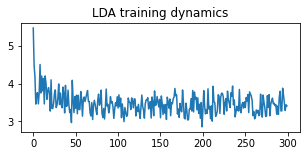

In [21]:
# Etr = lda.train(
#     dataFrame = Xpca,
#     coordLables = Xpca.columns,
#     Nbatch = 50,
#     schedule = [(0.1, 100), (0.05, 100), (0.01, 100)]
# )
# fig, Etr_plot = plt.subplots(figsize = (5, 2))
# Etr_plot.set_title('LDA training dynamics')
# Etr_plot.plot(np.arange(len(Etr)), Etr)
# plt.show()

Now we have trained LDA model. Lets evaluate the heights of each data-point (see eq. 6);

In [22]:
Xpca_tensor = torch.tensor(
    data = Xpca.values,
    dtype = torch.float
)
h_tensor = lda(Xpca_tensor)
h = pd.Series(
    data = h_tensor.detach().squeeze(1).numpy(),
    name = 'h',
    index = Xpca.index
)

Megre the h-series with Xpca data:

In [23]:

Xpca_lda = Xpca.copy(deep = True) 
Xpca_lda.insert(loc = Xpca_lda.shape[1], column = 'h', value = h.values)

And perform PCA again in order to get rid of excess dimension:

In [24]:

Xlda, Llda, Vlda = pca(Xpca_lda, pc_num = 3)
Xlda = Xlda.rename(columns = {'PC0': 'LD0', 'PC1': 'LD1', 'PC2': 'LD2'})

Now we cat visualize the data and compare it:

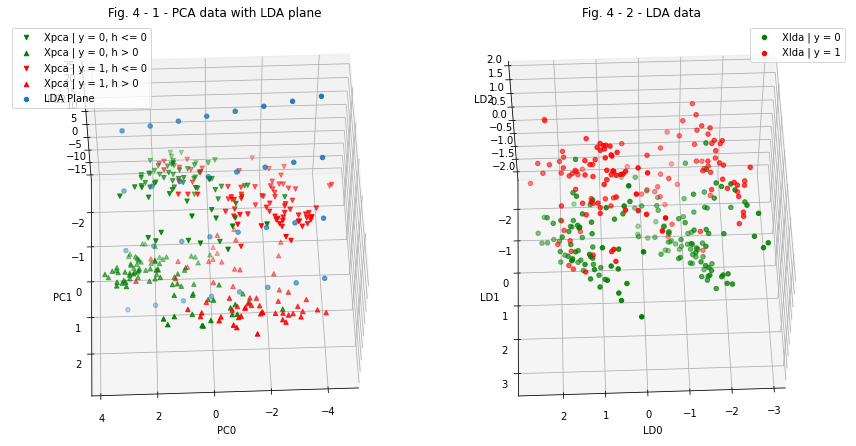

In [25]:
fig = plt.figure(figsize = (12, 7))
pca_lda_scatter = fig.add_subplot(121, projection = '3d')
lda_scatter = fig.add_subplot(122, projection = '3d')

for y_condition, y_title, y_colour in zip(
    [y == 0.0, y > 0.0],
    ['y = 0', 'y = 1'],
    ['g', 'r']
    ):
    lda_scatter.scatter(
        Xlda[y_condition]['LD0'].values, 
        Xlda[y_condition]['LD1'].values, 
        Xlda[y_condition]['LD2'].values,  
        color = y_colour,
        label = f'Xlda | {y_title}')

    for h_condition, h_title, h_point_style in zip(
        [h <= 0.0,  h > 0.0],
        ['h <= 0', 'h > 0'],
        ['v', '^']
        ):

        pca_lda_scatter.scatter(
            Xpca[y_condition & h_condition]['PC0'].values, 
            Xpca[y_condition & h_condition]['PC1'].values, 
            Xpca[y_condition & h_condition]['PC2'].values,  
            color = y_colour,
            marker = h_point_style,
            label = f'Xpca | {y_title}, {h_title}')

lda.plot(
    ax = pca_lda_scatter,
    x_range = np.arange(-4, 4, 1),
    y_range = np.arange(-2, 2, 1)
)

lda_scatter.set_title('Fig. 4 - 2 - LDA data')
lda_scatter.legend(); lda_scatter.grid()
lda_scatter.view_init(elev = 55, azim = 88)
lda_scatter.set_xlabel(Xlda.columns[0]); lda_scatter.set_ylabel(Xlda.columns[1]); lda_scatter.set_zlabel(Xlda.columns[2])
pca_lda_scatter.set_title('Fig. 4 - 1 - PCA data with LDA plane')
pca_lda_scatter.legend(); pca_lda_scatter.grid()
pca_lda_scatter.view_init(elev = 55, azim = 88)
pca_lda_scatter.set_xlabel(Xpca.columns[0]); pca_lda_scatter.set_ylabel(Xpca.columns[1]); pca_lda_scatter.set_zlabel(Xpca.columns[2])
fig.tight_layout()
plt.show()

### Conclusions regarding data transformations

In this section, we performed data dimensionality reduction using PCA method, visualized the obtained data in the three-dimensional space of coordinates $(PC_{0}, PC_{1}, PC_{2})$, found the concentration of data in two large clusters, and performed an additional transformation of coordinates using LDA method so that these clusters were located on opposite sides of the $(LD_{0}, LD_{2})$ coordinate plane (see fig. 4-1, 4-2).<br>

Now we have three datasets: $X$ - original dataset (direct measurements of patient parameters, 15 predictors total), $X_{pca}$ - PCA-derived dataset, and $X_{lda}$ - LDA-derived dataset.<br>
We can now build three logistic regression models predicting the diagnosis using these three datasets and compare the accuracy of these models.


## Prediction

We have come to the final stage of the study - building machine learning models to predict the diagnosis ($y$ value) from the observed data ($X, X_{pca}, X_{lda}$).<br>

In this work, we will use the logistic regression model from the sklern package. In order to obtain an objective assessment of the accuracy of the models, we will train each model using 3 different optimizers, calculate the confusion matrices, and evaluate the sensitivity and specificity of the models.

c:\PRJ\Heart diseases\Diagnostics-of-heart-disease\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


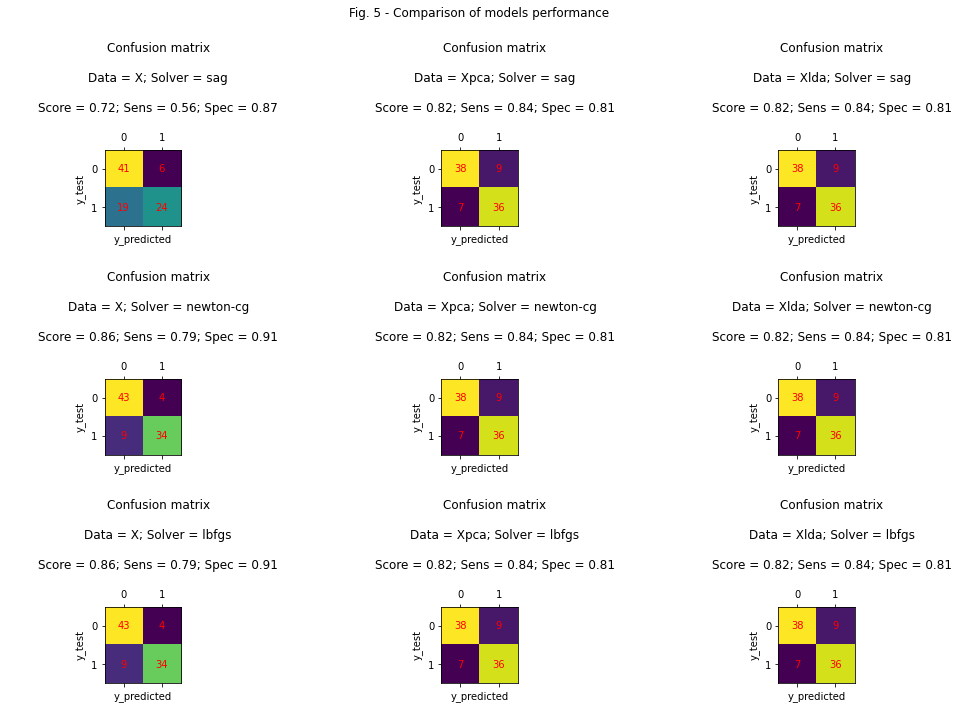

In [26]:
solvers = ['sag', 'newton-cg', 'lbfgs']
datasets = {
    'X': X,
    'Xpca': Xpca,
    'Xlda': Xlda
}

fig, ax = plt.subplots(nrows = len(solvers), ncols = len(datasets), figsize = (15, 10))

for row, solver in enumerate(solvers):
    for col, (data_title, data) in enumerate(datasets.items()):
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state = 2)

        logRegression = LogisticRegression(
            penalty = 'l2',
            tol = 0.01,
            solver = solver)

        logRegression.fit(X_train, y_train)

        y_predicted = logRegression.predict(X_test)
        score = logRegression.score(X_test, y_test)
        confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)

        ax[row, col].matshow(confusion_matrix)
        ax[row, col].set_ylabel('y_test')
        ax[row, col].set_xlabel('y_predicted')

        (I, J) = confusion_matrix.shape
        for i in range(I):
            for j in range(J):
                ax[row, col].text(j, i, confusion_matrix[i, j], ha="center", va="center", color="r")
        
        true_positives = confusion_matrix[1, 1]
        true_negatives = confusion_matrix[0, 0]
        false_positives = confusion_matrix[0, 1]
        false_negatives = confusion_matrix[1, 0]

        sensitivity = true_positives / (true_positives + false_negatives)
        specificity = true_negatives / (true_negatives + false_positives)

        ax[row, col].set_title(f"""
        Confusion matrix\n
        Data = {data_title}; Solver = {solver}\n
        Score = {score :.2f}; Sens = {sensitivity :.2f}; Spec = {specificity :.2f}
        """)
fig.suptitle('Fig. 5 - Comparison of models performance')
fig.tight_layout()
plt.show()


## Conclusions

From the data observed in Figure 5, the following conclusions can be made:

- Models using data $X_{pca}$ and $X_{lda}$ are not sensitive to the choice of optimizer - they achieved the same results in different tests.
- The model using data $X$ achieved the worst results when using the sag optimizer, and the best results with the newton-cg and lbfgs optimizers.
- We could mistakenly conclude that the use of PCA and LDA was unnecessary, because the $X$-based model without any data preprocessing achieved the best result. But let's take a look at the sensitivity of the three models ("Sens" in the figure). Sensitivity measures how well the model predicts a true-positive diagnosis in patients who actually have heart disease. In this case, sensitivity is the most important factor of models performance comparison, because we would rather make a mistake and give a false positive diagnosis to a healthy patient than a false negative to a sick one. Thus, we conclude that models based on $X_{pca}$ and $X_{lda}$ have a significantly better performance.